<a href="https://colab.research.google.com/github/Spruce-tone/pytorch-tutorial/blob/main/003%20%5Blightning%5D%20initialization%20and%20optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def check_dir(PATH, type_check='dir'):
    assert PATH not in ['dir', 'file'], 'type_check must be "dir" or "file"'
    
    if type_check=='dir':
        if not os.path.isdir(PATH):
            os.makedirs(PATH, exist_ok=True)
    
    elif type_check=='file':
        return os.path.isfile(PATH)

DATASET_PATH = './data'
CHECKPOINT_PATH = './saved_models/InitOptim'
check_dir(DATASET_PATH, 'dir')
check_dir(CHECKPOINT_PATH, 'dir')

In [1]:
print('New')

New


In [ ]:
import copy
import json
import math
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from IPython.display import set_matplotlib_formats
from matplotlib import cm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

sns.set()

In [ ]:
# random_seed = 42

# def set_seed(seed):
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     random.seed(seed)
    
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed) # if use multi-GPU

pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set_seed(random_seed)

device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda:0')
print(device)
print(torch.cuda.get_device_name(0))

Global seed set to 42


cuda:0
NVIDIA GeForce RTX 3080 Ti


In [ ]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"

# Files to download
pretrained_files = [
    "FashionMNIST_SGD.config",
    "FashionMNIST_SGD_results.json",
    "FashionMNIST_SGD.tar",
    "FashionMNIST_SGDMom.config",
    "FashionMNIST_SGDMom_results.json",
    "FashionMNIST_SGDMom.tar",
    "FashionMNIST_Adam.config",
    "FashionMNIST_Adam_results.json",
    "FashionMNIST_Adam.tar",
]

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

In [ ]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False, pin_memory=True)

In [ ]:
print('Mean', (train_dataset.data.float() / 255.0).mean().item())
print('Std', (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [ ]:
imgs, _ = next(iter(train_loader))

print(f'Mean : {imgs.mean().item():5.4f}')
print(f'Standard deviation : {imgs.std().item():5.3f}')
print(f'Maximum : {imgs.max().item():5.3f}')
print(f'Minimum : {imgs.min().item():5.3f}')

Mean : 0.0017
Standard deviation : 0.999
Maximum : 2.022
Minimum : -0.810


In [ ]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        
        self.layers = nn.ModuleList(layers)
        
        self.config = {
            'act_fn' : act_fn.__class__.__name__,
            'input_size' : input_size,
            'num_classes' : num_classes,
            'hidden_sizes' : hidden_sizes,}
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {'tanh' : nn.Tanh, 'relu' : nn.ReLU, 'identity' : Identity}

In [ ]:
##############################################################


def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


##############################################################


def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


##############################################################


def visualize_gradients(model, color="C0", print_variance=False):
    """
    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)  # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    # Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


##############################################################


def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

In [ ]:
model = BaseNetwork(act_fn=Identity()).to(device)

In [ ]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)

In [ ]:
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        print(val_dict[key].mean(), val_dict[key].std()) 

        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

-5.110142e-09 3.609928e-07
-1.8150304e-08 3.5527137e-15
-3.8255035e-08 0.0
-7.957184e-08 0.0
-2.0802022e-06 0.41033402


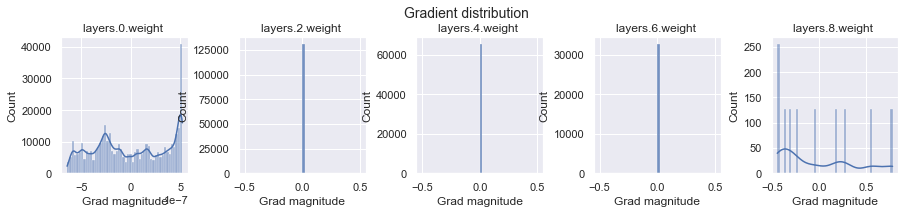

0.03629658 1.4349881
0.09792716 3.6743107
0.13035978 4.7041283
0.17187384 6.022484
0.11498992 3.8552032


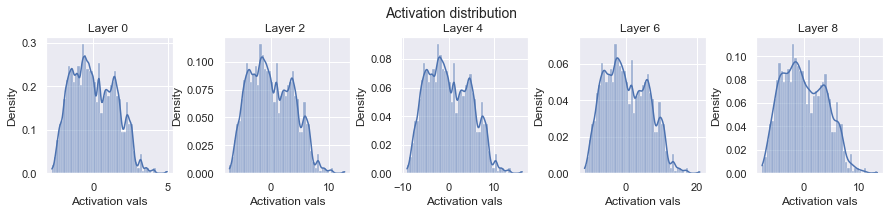

Layer 0 - Variance: 2.0591909885406494
Layer 2 - Variance: 13.500558853149414
Layer 4 - Variance: 22.128822326660156
Layer 6 - Variance: 36.27030944824219
Layer 8 - Variance: 14.862591743469238


In [ ]:
const_init(model, fill=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

In [ ]:
model.eval()
small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
imgs, labels = next(iter(small_loader))
imgs, labels = imgs.to(device), labels.to(device)

In [ ]:
feats = imgs.view(imgs.shape[0], -1)
activations = {}
with torch.no_grad():
    for layer_index, layer in enumerate(model.layers):
        feats = layer(feats)
        if isinstance(layer, nn.Linear):
            activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

In [ ]:
activations

{'Layer 0': array([ 0.31757587,  0.31757587,  0.31757587, ..., -1.5601048 ,
        -1.5601048 , -1.5601048 ], dtype=float32),
 'Layer 2': array([ 0.8182947,  0.8182947,  0.8182947, ..., -3.9908497, -3.9908497,
        -3.9908497], dtype=float32),
 'Layer 4': array([ 1.0527221,  1.0527221,  1.0527221, ..., -5.103583 , -5.103583 ,
        -5.103583 ], dtype=float32),
 'Layer 6': array([ 1.3527844,  1.3527844,  1.3527844, ..., -6.5313816, -6.5313816,
        -6.5313816], dtype=float32),
 'Layer 8': array([ 0.87080806,  0.87080806,  0.87080806, ..., -4.1758924 ,
        -4.1758924 , -4.1758924 ], dtype=float32)}

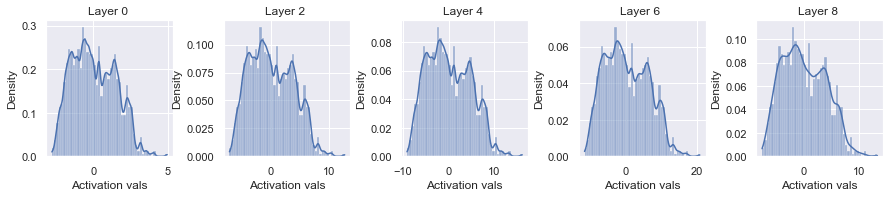

In [ ]:
fig = plot_dists(activations, color='C0', stat="density", xlabel="Activation vals")

In [ ]:
def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################